# Descarga de datos desde Postgres

In [2]:
!pip install psycopg2-binary sqlalchemy pandas matplotlib seaborn scikit-learn


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split


In [4]:

pg_host = os.getenv("PG_HOST")
pg_port = os.getenv("PG_PORT")
pg_db = os.getenv("PG_DB")
pg_user = os.getenv("PG_USER")
pg_password = os.getenv("PG_PASSWORD")

engine = create_engine(
    f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}"
)

# 1. Definición del Problema de Negocio

**Objetivo:** Predecir la dirección del mercado para el día siguiente ($t+1$).

**Target (`target_up`):**
Es una variable binaria:
- `1`: Si el precio de cierre de mañana es MAYOR que el de hoy (Subida).
- `0`: Si el precio de cierre de mañana es MENOR o IGUAL al de hoy (Bajada).

$$
target\_up_{t} = \begin{cases} 
1 & \text{if } Close_{t+1} > Close_{t} \\
0 & \text{if } Close_{t+1} \leq Close_{t}
\end{cases}
$$

**Decisión que habilita:**
- Si el modelo predice `1`: **Comprar/Mantener (Long)** al cierre de hoy.
- Si el modelo predice `0`: **Vender/Short** o mantenerse en Cash.

# 2. Carga de datos 

In [5]:
df = pd.read_sql("SELECT * FROM analytics.prices_daily_features", engine)
# target_up (close > open)
df['target_up'] = (df['close'] > df['open']).astype(int)
df.head()

,date,ticker,open,high,low,close,volume,year,month,day_of_week,...,is_friday,is_earning_day,return_close_open,return_prev_close,volatility_7_days,volatility_30_days,close_lag1,ingested_at_utc,run_id,target_up
0,2020-01-02,NVDA,5.96875,5.99775,5.91800,5.99775,237536000,2020,1,2,...,0,0,0.004859,NaN,NaN,NaN,NaN,2025-12-06 02:59:22.922039,NVDA-2020-2024,1
1,2020-01-03,NVDA,5.87750,5.94575,5.85250,5.90175,205384000,2020,1,3,...,1,0,0.004126,-0.016006,NaN,NaN,5.99775,2025-12-06 02:59:22.922039,NVDA-2020-2024,1
2,2020-01-06,NVDA,5.80800,5.93175,5.78175,5.92650,262636000,2020,1,6,...,0,0,0.020403,0.004194,NaN,NaN,5.90175,2025-12-06 02:59:22.922039,NVDA-2020-2024,1
3,2020-01-07,NVDA,5.95500,6.04425,5.90975,5.99825,314856000,2020,1,7,...,0,0,0.007263,0.012107,0.014283,0.014283,5.92650,2025-12-06 02:59:22.922039,NVDA-2020-2024,1
4,2020-01-08,NVDA,5.99400,6.05100,5.95375,6.00950,277108000,2020,1,8,...,0,0,0.002586,0.001876,0.014497,0.014497,5.99825,2025-12-06 02:59:22.922039,NVDA-2020-2024,1


# 3. EDA breve

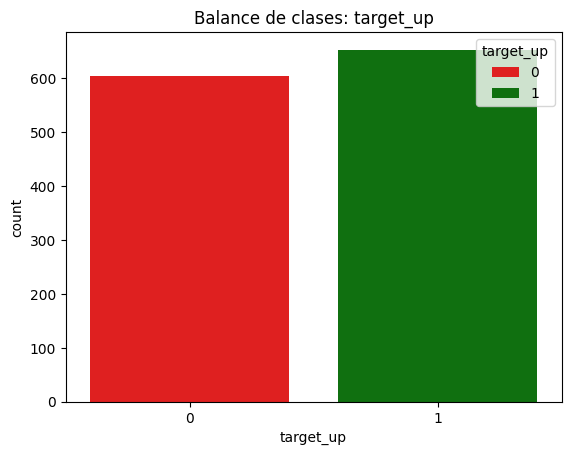

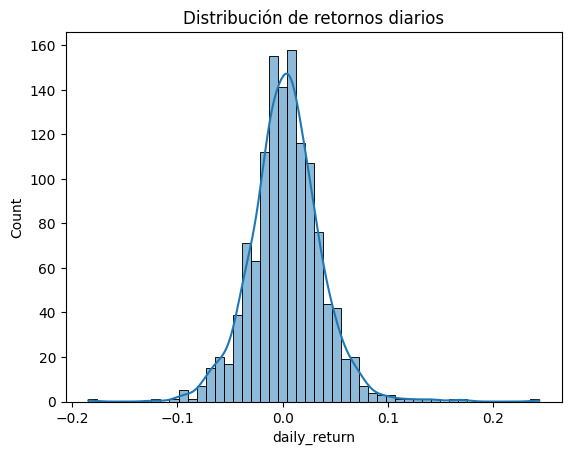

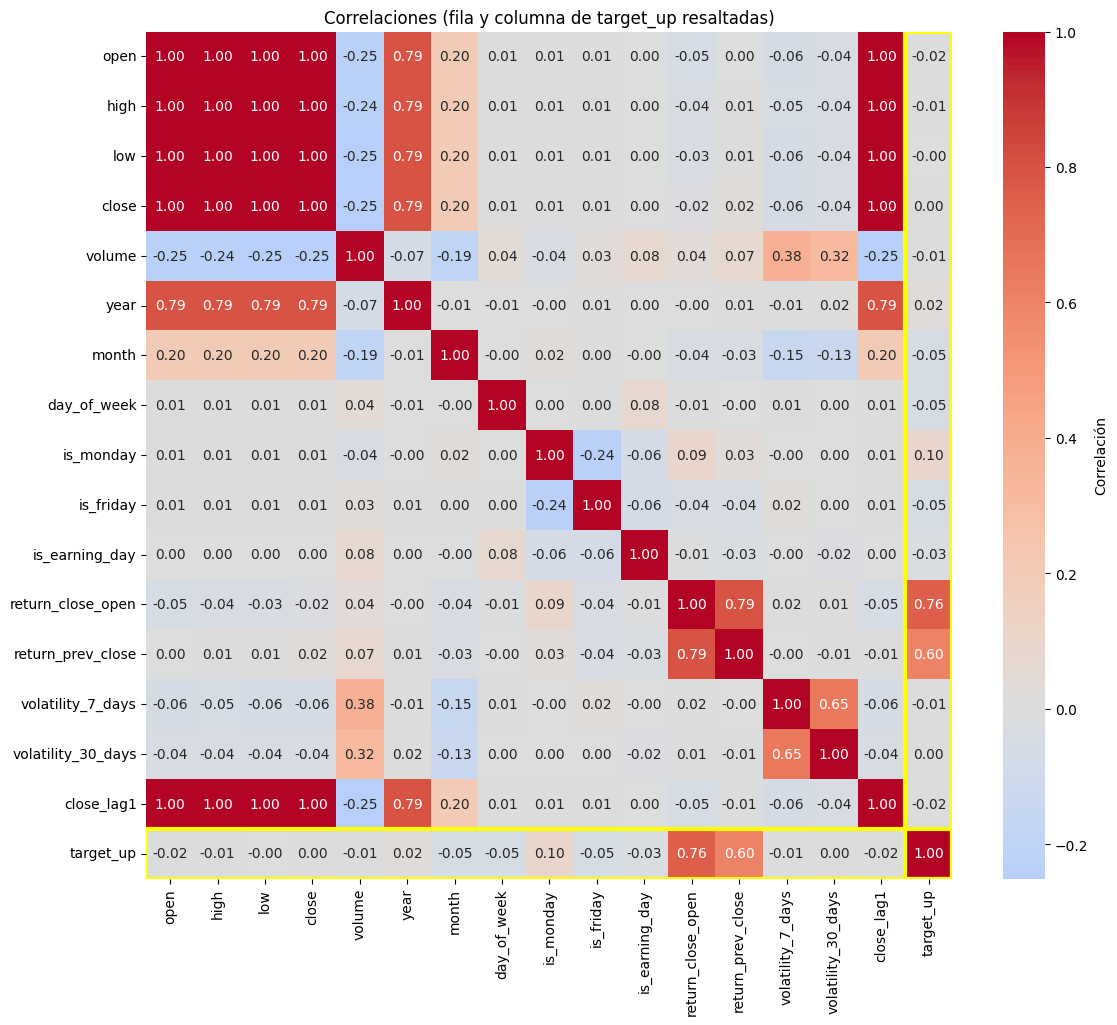

In [6]:
# EDA
# Balance de clases.
sns.countplot(x='target_up',hue='target_up', data=df, palette={1: 'green', 0: 'red'}) 
plt.title('Balance de clases: target_up')
plt.show()

# Distribucion de retornos diarios
df['daily_return'] = df['close'].pct_change() 
sns.histplot(df['daily_return'].dropna(), bins=50, kde=True)
plt.title('Distribución de retornos diarios')
plt.show()
# dropear daily_return para evitar confusión
df.drop(columns=['daily_return'], inplace=True)

# correlaciones simples (incluyendo sentimiento si aplica).

# quitar columnas no numéricas o irrelevantes
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()
# crear matriz donde target_up tiene un borde grueso
corr = df.corr(numeric_only=True)

plt.figure(figsize=(13, 11))
ax = sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    cbar_kws={"label": "Correlación"},
)

# sombrear fila + columna
idx = corr.columns.get_loc("target_up")

# sombrear fila
ax.add_patch(
    plt.Rectangle((0, idx), len(corr), 1, fill=False, edgecolor="yellow", lw=3)
)

# sombrear columna
ax.add_patch(
    plt.Rectangle((idx, 0), 1, len(corr), fill=False, edgecolor="yellow", lw=3)
)

plt.title("Correlaciones (fila y columna de target_up resaltadas)")
plt.show()


# Features y target

## Justificación
En series de tiempo financieras, solo podemos usar información que ya existe antes de la apertura del día que queremos predecir.
Por este motivo no usamos valores del mismo día como open, high, low, close o volume para predecir el mismo día:
esos datos aún no existirían al momento de tomar la decisión.
Se usa lags para:
- Evitar leakage (información del futuro)
- Capturar comportamiento reciente del mercado

In [ ]:
# Seleccionar features y el target para ML
cols_to_lag = ['open', 'high', 'low', 'close', 'volume', 'return_prev_close', 'return_close_open']
for col in cols_to_lag:
    df[f'{col}_lag1'] = df.groupby('ticker')[col].shift(1)

feature_cols = ['open', 'open_lag1',
                'high_lag1', 'low_lag1', 'close_lag1',
                'volume_lag1', 'return_prev_close_lag1', 'return_close_open_lag1',
                'volatility_7_days', 'volatility_30_days', 'year', 'month', 'day_of_week',
                'is_monday', 'is_friday', 'is_earning_day']
target_col = 'target_up'

df['date'] = pd.to_datetime(df['date'])


(1257, 27)

# 5. Split temporal (Train / Val / Test)

In [ ]:
# train 2020, 2021, 2022, validation 2023, test 2024
train_df = df[df['date'] < pd.to_datetime('2023-01-01')]
val_df = df[(df['date'] >= pd.to_datetime('2023-01-01')) & (df['date'] < pd.to_datetime('2024-01-01'))]
test_df = df[df['date'] >= pd.to_datetime('2024-01-01')]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]



,open,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,return_prev_close_lag1,return_close_open_lag1,volatility_7_days,volatility_30_days,year,month,day_of_week,is_monday,is_friday,is_earning_day
0,5.96875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,1,2,0,0,0
1,5.87750,5.96875,5.99775,5.91800,5.99775,237536000.0,NaN,0.004859,NaN,NaN,2020,1,3,0,1,0
2,5.80800,5.87750,5.94575,5.85250,5.90175,205384000.0,-0.016006,0.004126,NaN,NaN,2020,1,6,1,0,0
3,5.95500,5.80800,5.93175,5.78175,5.92650,262636000.0,0.004194,0.020403,0.014283,0.014283,2020,1,7,0,0,0
4,5.99400,5.95500,6.04425,5.90975,5.99825,314856000.0,0.012107,0.007263,0.014497,0.014497,2020,1,8,0,0,0


# 6. Preprocesamiento

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# numerical features
numerical_features = feature_cols  # dow, month, podrian ser categóricas pero las dejamos numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # imputar valores faltantes con la media
    ('scaler', StandardScaler()) # estandarizar
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ]
)

# 7. Modelado

## 7.1 Lineales
### 7.1.1 Logistic Regression

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

Buscando mejores hiperparametros para Logistic Regression


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_

Mejores hiperparametros Logistic Regression: {'classifier__C': 0.01, 'classifier__class_weight': None, 'classifier__l1_ratio': 0, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Logistic Regression - Validation Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.55      1.00      0.71       137

    accuracy                           0.55       250
   macro avg       0.27      0.50      0.35       250
weighted avg       0.30      0.55      0.39       250



/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no 

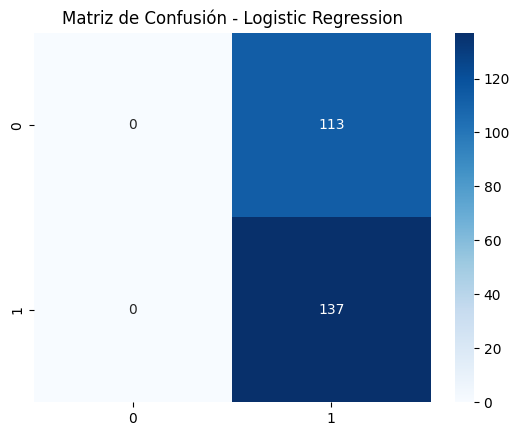

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Logistic Regression - Train Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       374
           1       0.51      1.00      0.67       382

    accuracy                           0.51       756
   macro avg       0.25      0.50      0.34       756
weighted avg       0.26      0.51      0.34       756



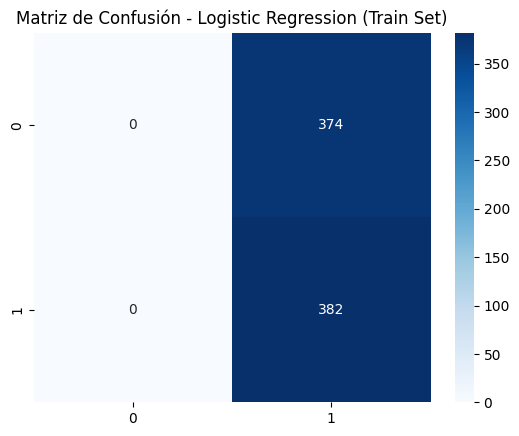

In [ ]:
# Logistic Regression

# Usar GridSearchCV o RandomizedSearchCV (puedes usar TimeSeriesSplit o validación simple temporal).
# Registrar métricas en Train y Validación.
# Métricas: Accuracy, Precision, Recall, F1, ROC-AUC.
# Matriz de confusión
# Comparación tabular entre los 7 modelos.

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Crear pipeline completo
pipeline_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000))])
# Hiperparámetros para GridSearch
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10], # regularización
    'classifier__penalty': ['l2', 'l1', 'elasticnet'], # tipo de penalización
    'classifier__solver': ['saga'], # saga soporta l1 y elasticnet
    'classifier__class_weight': [None, 'balanced'], # manejar desequilibrio de clases
    'classifier__l1_ratio': [0, 0.3, 0.5, 0.8, 1], # solo usado si penalty es 'elasticnet'
    'classifier__max_iter': [1000, 3000, 5000]
}
print("Buscando mejores hiperparametros para Logistic Regression")
grid_search_logreg = GridSearchCV(pipeline_logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)
best_logreg = grid_search_logreg.best_estimator_
y_val_pred_logreg = best_logreg.predict(X_val)
print("Mejores hiperparametros Logistic Regression:", grid_search_logreg.best_params_)

# Ver metricas del validation set
print("Logistic Regression - Validation Set")
print(classification_report(y_val, y_val_pred_logreg))
cm_logreg = confusion_matrix(y_val, y_val_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()

# Ver metricas del train set
y_train_pred_logreg = best_logreg.predict(X_train)
print("Logistic Regression - Train Set")
print(classification_report(y_train, y_train_pred_logreg))
cm_train_logreg = confusion_matrix(y_train, y_train_pred_logreg)
sns.heatmap(cm_train_logreg, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression (Train Set)')
plt.show()

## 7.2 Arbol de decisión
###  7.2.1 Decision Tree Classifier

Buscando mejores hiperparametros para Decision Tree
Mejores hiperparametros Decision Tree: {'classifier__class_weight': None, 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
Decision Tree Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.41      0.31      0.35       113
           1       0.52      0.63      0.57       137

    accuracy                           0.48       250
   macro avg       0.47      0.47      0.46       250
weighted avg       0.47      0.48      0.47       250



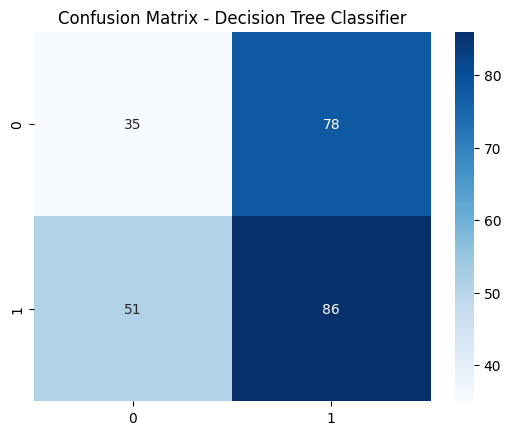

Decision Tree Classifier - Train Set
              precision    recall  f1-score   support

           0       0.79      0.94      0.85       374
           1       0.92      0.75      0.83       382

    accuracy                           0.84       756
   macro avg       0.85      0.84      0.84       756
weighted avg       0.86      0.84      0.84       756



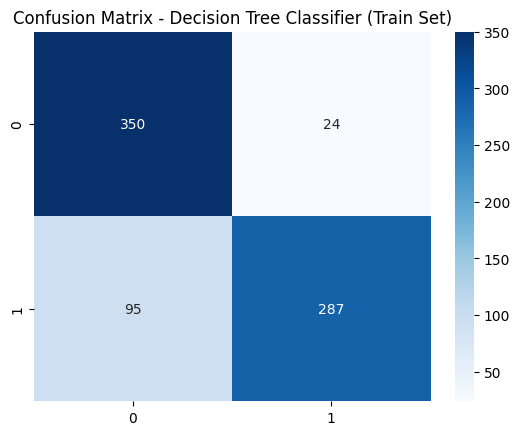

In [27]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Create pipeline completo
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier())])
param_grid_dt = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': [None, 'balanced']
}
print("Buscando mejores hiperparametros para Decision Tree")
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
y_val_pred_dt = best_dt.predict(X_val)
print("Mejores hiperparametros Decision Tree:", grid_search_dt.best_params_)

# Ver metricas del validation set
print("Decision Tree Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_dt))
cm_dt = confusion_matrix(y_val, y_val_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_dt = best_dt.predict(X_train)
print("Decision Tree Classifier - Train Set")
print(classification_report(y_train, y_train_pred_dt))
cm_train_dt = confusion_matrix(y_train, y_train_pred_dt)
sns.heatmap(cm_train_dt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree Classifier (Train Set)")
plt.show()

## 7.3 Random Forest
### 7.3.1 Random Forest Classifier

Buscando mejores hiperparametros para Random Forest
Mejores hiperparametros Random Forest: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Random Forest Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.46      0.94      0.62       113
           1       0.65      0.09      0.17       137

    accuracy                           0.48       250
   macro avg       0.56      0.52      0.39       250
weighted avg       0.56      0.48      0.37       250



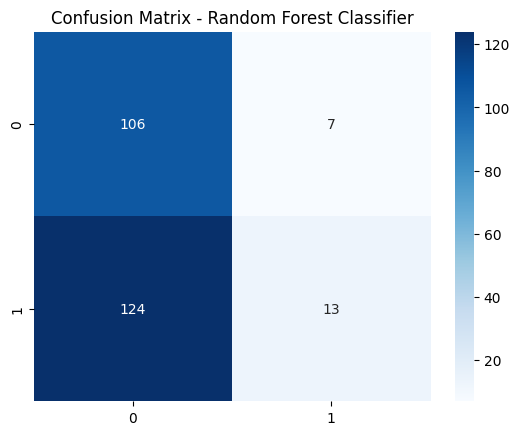

Random Forest Classifier - Train Set
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       374
           1       0.72      0.63      0.67       382

    accuracy                           0.69       756
   macro avg       0.69      0.69      0.69       756
weighted avg       0.69      0.69      0.69       756



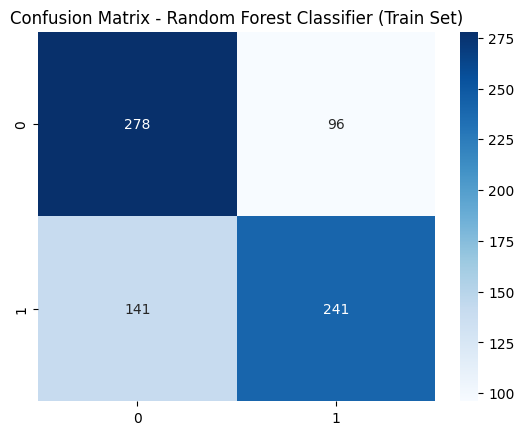

In [ ]:
# random forest classifier
from sklearn.ensemble import RandomForestClassifier
# Create pipeline completo
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier())])

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [10, 20, 40],
    'classifier__min_samples_leaf': [10, 15, 20],
    'classifier__max_features': ['sqrt', 'log2', 0.5], 
    'classifier__criterion': ['gini', 'entropy']
}

print("Buscando mejores hiperparametros para Random Forest")
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_val_pred_rf = best_rf.predict(X_val)
print("Mejores hiperparametros Random Forest:", grid_search_rf.best_params_)

# Ver metricas del validation set
print("Random Forest Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_rf))
cm_rf = confusion_matrix(y_val, y_val_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.show()

# Ver metricas del train set
y_train_pred_rf = best_rf.predict(X_train)
print("Random Forest Classifier - Train Set")
print(classification_report(y_train, y_train_pred_rf))
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest Classifier (Train Set)")
plt.show()

print('f1 score train logreg:', f1_score(y_train, y_train_pred_logreg))

### 7.3.2 Extra Tree Classifier

Buscando mejores hiperparametros para Extra Trees
Mejores hiperparametros Extra Trees: {'classifier__class_weight': None, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
Extra Trees Classifier - Validation Set
              precision    recall  f1-score   support

           0       0.50      0.84      0.63       113
           1       0.70      0.31      0.43       137

    accuracy                           0.55       250
   macro avg       0.60      0.58      0.53       250
weighted avg       0.61      0.55      0.52       250



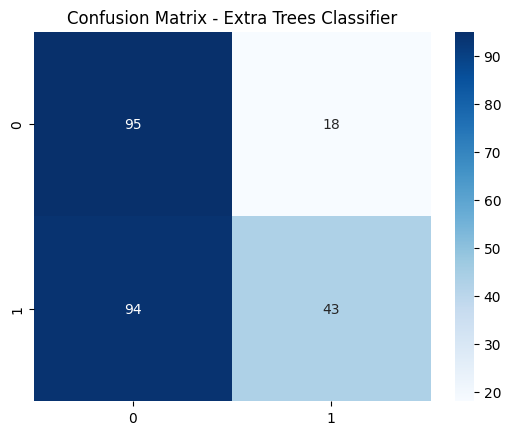

Extra Trees Classifier - Train Set
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       374
           1       0.73      0.77      0.75       382

    accuracy                           0.74       756
   macro avg       0.74      0.74      0.74       756
weighted avg       0.74      0.74      0.74       756



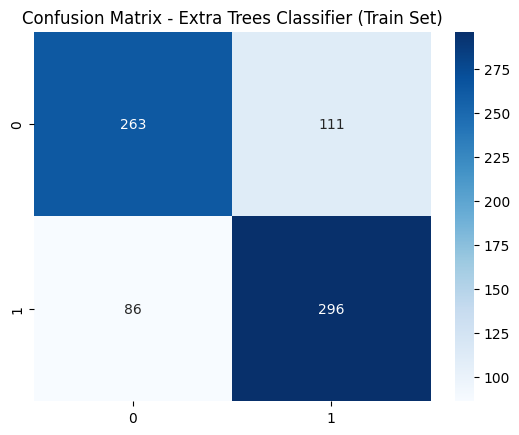

In [33]:
# Extra Trees Classifier
from sklearn.ensemble import ExtraTreesClassifier
# Create pipeline completo
pipeline_et = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', ExtraTreesClassifier())])
param_grid_et = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [10, 15, 20],
    'classifier__min_samples_split': [5, 15, 30],
    'classifier__min_samples_leaf': [5, 10, 20],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
}
print("Buscando mejores hiperparametros para Extra Trees")
grid_search_et = GridSearchCV(pipeline_et, param_grid_et, cv=5, scoring='f1', n_jobs=-1)
grid_search_et.fit(X_train, y_train)
best_et = grid_search_et.best_estimator_
y_val_pred_et = best_et.predict(X_val)
print("Mejores hiperparametros Extra Trees:", grid_search_et.best_params_)

# Ver metricas del validation set
print("Extra Trees Classifier - Validation Set")
print(classification_report(y_val, y_val_pred_et))
cm_et = confusion_matrix(y_val, y_val_pred_et)
sns.heatmap(cm_et, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Extra Trees Classifier")
plt.show()
# Ver metricas del train set
y_train_pred_et = best_et.predict(X_train)
print("Extra Trees Classifier - Train Set")
print(classification_report(y_train, y_train_pred_et))
cm_train_et = confusion_matrix(y_train, y_train_pred_et)
sns.heatmap(cm_train_et, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Extra Trees Classifier (Train Set)")
plt.show()

## 7.4 Boosting
### 7.4.1 Gradient Boosting

### 7.4.2 XGBoost

### 7.4.3 CatBoost